# compute spectra on mitgcm outputs

---

In [16]:
import os
import numpy as np
import dask
from dask_jobqueue import PBSCluster
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

#import xrft

#from utils import *
#from mitequinox import *
import mitequinox

# debug
from datetime import datetime
from time import sleep

In [6]:
# launch cluster and workers
#local_dir = os.getenv('HOME')+'/dask_scratch/'
local_dir = os.getenv('DATAWORK')+'/dask_scratch/'
#cluster = PBSCluster(queue='mpi_1', local_directory=os.getenv('DATAWORK')+'/dask', interface='ib0', \
cluster = PBSCluster(queue='mpi_1', local_directory=local_dir, interface='ib0', walltime='24:00:00',
                     threads=4, processes=7, memory='5GB', resource_spec='select=1:ncpus=28:mem=100g', 
                     death_timeout=100)
#                     job_extra=['Output_Path='+local_dir+'output.o', 'Error_Path='+local_dir+'output.e'])
#job_extra=['Output_Path='+local_dir+'output.o', 'Error_Path='+local_dir+'output.e'])

In [7]:
print(cluster.job_header)

#PBS -N dask-worker
#PBS -q mpi_1
#PBS -l select=1:ncpus=28:mem=100g
#PBS -l walltime=24:00:00


In [8]:
cluster.start_workers(4)

[2, 3, 4, 5]

In [10]:
while True:
    print(datetime.now().strftime("%a, %d %B %Y %I:%M:%S"))
    print(cluster.scheduler)
    sleep(10)

Thu, 05 April 2018 06:42:52
<Scheduler: "tcp://10.148.1.108:37240" processes: 21 cores: 84>
Thu, 05 April 2018 06:43:02
<Scheduler: "tcp://10.148.1.108:37240" processes: 21 cores: 84>
Thu, 05 April 2018 06:43:12
<Scheduler: "tcp://10.148.1.108:37240" processes: 21 cores: 84>
Thu, 05 April 2018 06:43:22
<Scheduler: "tcp://10.148.1.108:37240" processes: 21 cores: 84>
Thu, 05 April 2018 06:43:32
<Scheduler: "tcp://10.148.1.108:37240" processes: 21 cores: 84>
Thu, 05 April 2018 06:43:42
<Scheduler: "tcp://10.148.1.108:37240" processes: 21 cores: 84>


KeyboardInterrupt: 

In [23]:
cluster.scheduler

<Scheduler: "tcp://10.148.1.108:37240" processes: 21 cores: 84>

In [12]:
### get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)
#client = Client(scheduler_file=os.path.expanduser('/home1/scratch/aponte/dask/scheduler.json'), timeout='20s')
# upload utils.py to workers
#client.upload_file('utils.py')

distributed.scheduler - INFO - Receive client connection: Client-4b54404c-3901-11e8-81cc-0cc47a3f6317


In [13]:
client

Client Scheduler: tcp://10.148.1.108:37240 Dashboard: http://10.148.1.108:34685/status,Cluster Workers: 21 Cores: 84 Memory: 105.00 GB


In [20]:
#client.upload_file('utils.py')

In [3]:
#client

Client Scheduler: tcp://10.148.1.21:8786 Dashboard: http://10.148.1.21:8787,Cluster Workers: 118 Cores: 472 Memory: 1180.00 GB


In [15]:

data_dir = '/home/datawork-lops-osi/data/mit4320/Eta/'
grid_dir = '/home/datawork-lops-osi/data/mit4320/grid/'

iters, time = get_iters_time('Eta', data_dir, delta_t=25.)

ds = get_compressed_data('Eta', data_dir, grid_dir, iters='all', time=time, client=client)
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))


NameError: name 'get_iters_time' is not defined

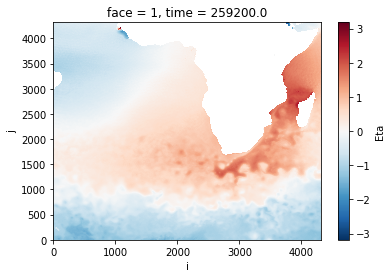

In [18]:
ds['Eta'].isel(face=1, time=0).plot()

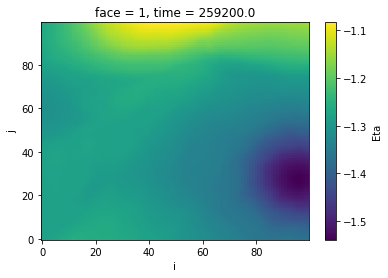

In [19]:
ds['Eta'].isel(face=1, time=0, i=slice(0,100), j=slice(0,100)).plot()

CancelledError: ('getitem-c62251c9f5b13c46d1a624da13098897', 2618)

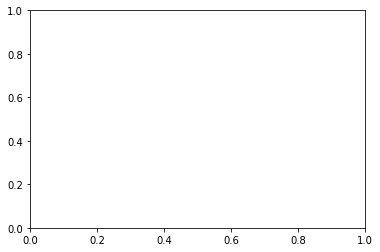

In [22]:
%time ds['Eta'].isel(face=1, i=0, j=0).plot()

In [ ]:
%time ds['Eta'].isel(face=1, i=slice(0,100), j=slice(0,100)).mean(dim=['i','j']).plot()

---

# basic statistics

In [24]:
m1 = ds['Eta'].isel(face=1).mean(['time'])

In [ ]:
m1.plot()

In [27]:
client.restart()

distributed.scheduler - ERROR - Not all workers responded positively: ['timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed out', 'timed

Client Scheduler: tcp://10.148.1.110:59968 Dashboard: http://10.148.1.110:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [40]:
client

Client Scheduler: tcp://10.148.1.110:59968 Dashboard: http://10.148.1.110:8787/status,Cluster Workers: 42 Cores: 168 Memory: 420.00 GB


In [24]:
client.close()
cluster.stop_workers(cluster.jobs)

distributed.scheduler - INFO - Remove client Client-4b54404c-3901-11e8-81cc-0cc47a3f6317
distributed.scheduler - INFO - Close client connection: Client-4b54404c-3901-11e8-81cc-0cc47a3f6317
distributed.scheduler - INFO - Worker 'tcp://10.148.1.12:38916' failed from closed comm: in <closed TCP>: Stream is closed
distributed.scheduler - INFO - Remove worker tcp://10.148.1.12:38916
distributed.scheduler - INFO - Worker 'tcp://10.148.1.12:42478' failed from closed comm: in <closed TCP>: Stream is closed
distributed.scheduler - INFO - Remove worker tcp://10.148.1.12:42478
distributed.scheduler - INFO - Worker 'tcp://10.148.1.12:38955' failed from closed comm: in <closed TCP>: Stream is closed
distributed.scheduler - INFO - Remove worker tcp://10.148.1.12:38955
distributed.scheduler - INFO - Worker 'tcp://10.148.1.12:44578' failed from closed comm: in <closed TCP>: Stream is closed
distributed.scheduler - INFO - Remove worker tcp://10.148.1.12:44578
distributed.scheduler - INFO - Worker 'tcp:

In [25]:
del cluster